# About the analysis

We are trying to predict energy consuption for 1449 buildings. The value we are trying to predict is the meter_reading

Each building can have multiple meters - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}. Not every building has all meter types.

We are given:
    
Historic meter reading data by timestamp for the building (train.csv)

Building metadata including the building use, square ft area, year build(building_meta.csv). This data does not change between the training and test set.

Weather data with predicpitation, cloud_coverage, air_temperature and more (weather_[train/test].csv)

## In addition  we are provided 

csvs to be used for submission:
    
test.csv which contains the meter, building id and timestamp we will be predicting for

sample_submission.csv which contains all the future data we would like to predict

# Objective

##  In this competition, you’ll develop accurate predictions of metered building energy usage in the following areas: chilled water, electric, natural gas, hot water, and steam meters. The data comes from over 1,000 buildings over a three-year timeframe.

In [1]:
#import important tools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train=pd.read_csv("train2.csv")
weather_train=pd.read_csv('weather_train.csv')
weather_test=pd.read_csv("weather_test.csv")
build=pd.read_csv("building_metadata.csv")

In [5]:
#setting the timestamp
train['timestamp'] = pd.to_datetime(train['timestamp'])
weather_train['timestamp'] = pd.to_datetime(weather_train['timestamp'])
weather_test['timestamp'] = pd.to_datetime(weather_test['timestamp'])

In [6]:
sns.set(style="whitegrid")
sns.set_color_codes("pastel")

### quick headups 

We are given one year of data (2016) and are asked to predict 2 years of meter readings.

This competition challenges you to build these counterfactual models across four energy types based on historic usage rates and observed weather. The dataset includes three years of hourly meter readings from over one thousand buildings at several different sites around the world.

In [7]:
meter_mapping={0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}

In [9]:

train['meter_type'] = train['meter'].map(meter_mapping)

In [11]:
train.head(3)

,building_id,meter,timestamp,meter_reading,meter_type
0,0,0,2016-01-01,0.0,electricity
1,1,0,2016-01-01,0.0,electricity
2,2,0,2016-01-01,0.0,electricity


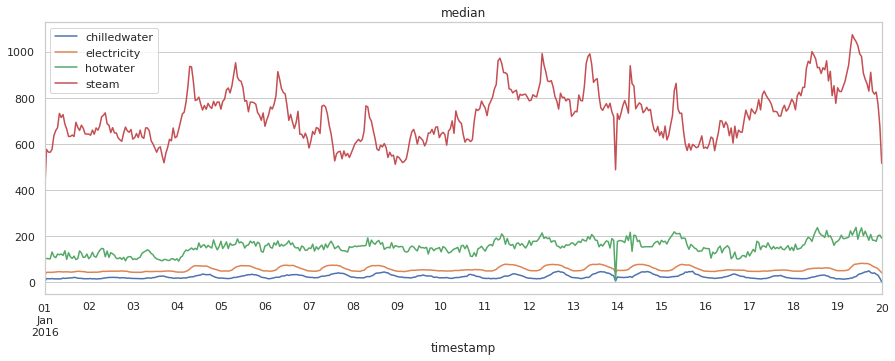

In [13]:

train.groupby(['timestamp','meter_type'])['meter_reading']\
.median()\
.reset_index().set_index('timestamp')\
.groupby('meter_type')['meter_reading']\
.plot(figsize=(15,5),title="median")
plt.legend()
plt.show()

on  january their was high demand of  enery for steam

followed by hot water which dropped sharpy on 14th of january

the enery for  elecricity and  chilled water remain relatively consants





In [14]:
train.describe()

,building_id,meter,meter_reading
count,1.048575e+06,1.048575e+06,1.048575e+06
mean,8.135641e+02,6.584574e-01,1.332728e+03
std,4.264461e+02,9.343969e-01,6.468032e+04
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.130000e+02,0.000000e+00,1.294000e+01
50%,9.080000e+02,0.000000e+00,6.465000e+01
75%,1.197000e+03,1.000000e+00,2.270000e+02
max,1.448000e+03,3.000000e+00,8.243400e+06


## Evaluating the Target Variable

As always we will start by looking at the target variable. As we have 1000+ buildings that we have meter data for. We will look at the meter data by meter type.



In [15]:
# meter data by meter type.
pd.DataFrame(train.groupby('meter_type')['meter_reading'].describe()
.astype(int))\
.sort_values('count',ascending=False)


,count,mean,std,min,25%,50%,75%,max
meter_type,,,,,,,,
electricity,632416,147,339,0,14,53,146,9116
chilledwater,207439,143,394,0,0,21,115,9268
steam,143157,8606,174866,0,201,719,2312,8243400
hotwater,65563,648,2512,0,26,148,600,108799


Electricity meters are 3x more common than the next meter type (chilledwater)

Steam has much larger average meter values than the rest ( 8606 average reading)

####  Plotting the distribution of the target.

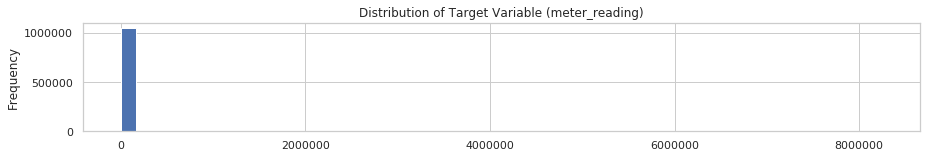

In [16]:

train['meter_reading'].plot(kind='hist',bins=50,figsize=(15,2),title="Distribution of Target Variable (meter_reading)")
plt.show()

Removing the high values we can get a better idea about the distribution of values. We may want to create different models for different buildings.

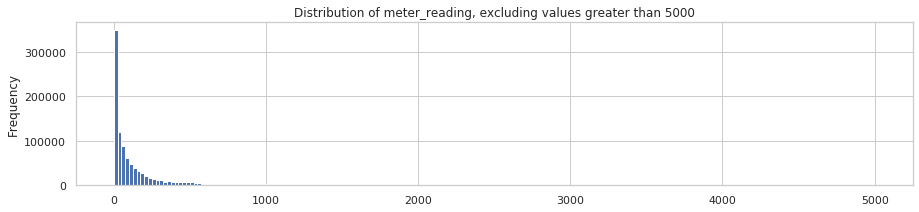

In [18]:

train.query("meter_reading<5000")['meter_reading']\
.plot(kind='hist',figsize=(15,3),title="Distribution of meter_reading, excluding values greater than 5000",
      bins=200)
plt.show()

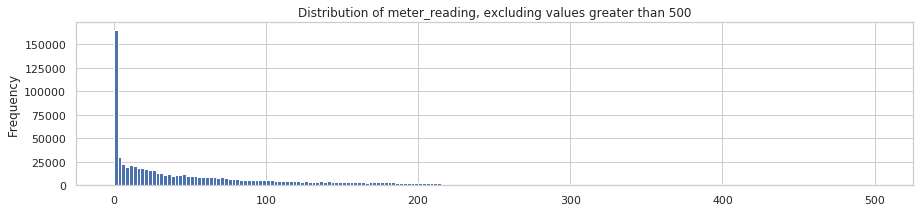

In [22]:
train.query('meter_reading<500')['meter_reading']\
.plot(kind='hist',figsize=(15,3),title=("Distribution of meter_reading, excluding values greater than 500"),
     bins=200)
plt.show()

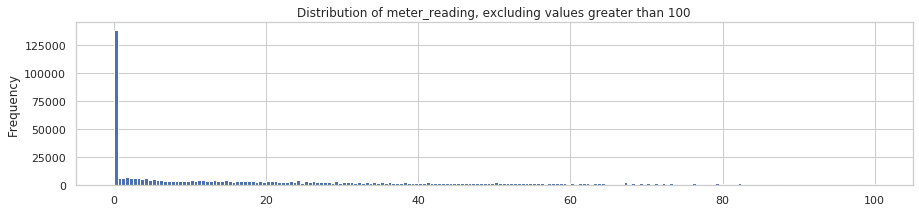

In [21]:
train.query('meter_reading<100')['meter_reading']\
.plot(kind='hist',figsize=(15,3),title="Distribution of meter_reading, excluding values greater than 100",
     bins=200)
plt.show()

### Target for a single building /w Multiple Meters. Viewing over Time.

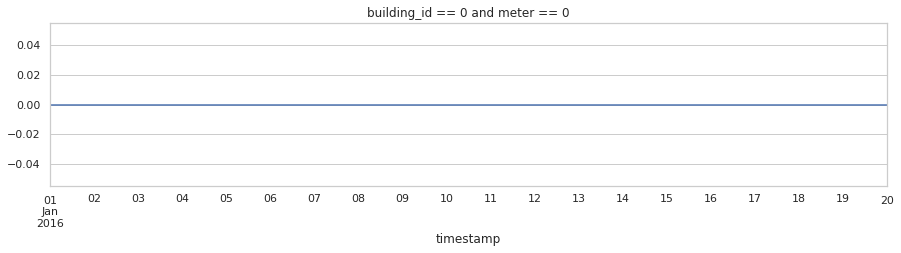

In [26]:

train.query('building_id == 0 and meter == 0')\
.set_index('timestamp')['meter_reading']\
.plot(figsize=(15,3),title='building_id == 0 and meter == 0')

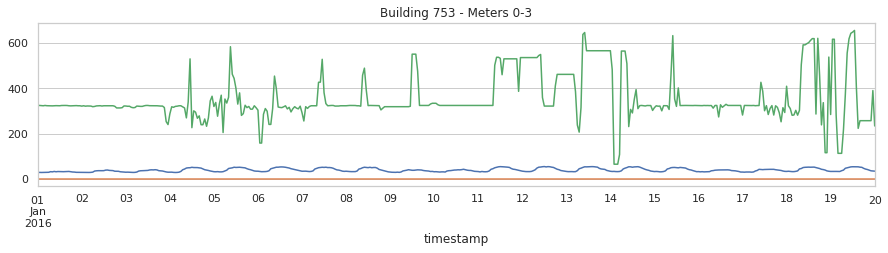

In [32]:

train.query('building_id == 753').set_index('timestamp').groupby('meter')['meter_reading']\
.plot(figsize=(15,3),title="Building 753 - Meters 0-3")
plt.show()


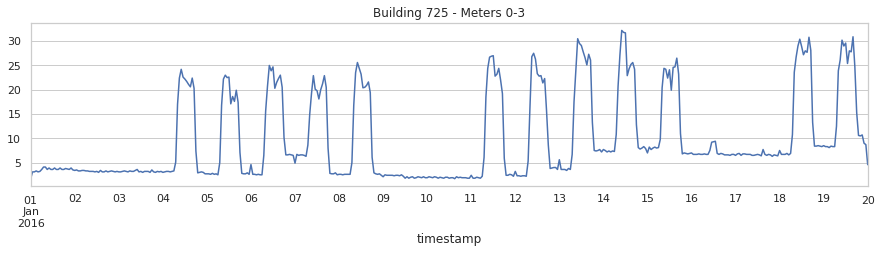

In [33]:
train.query('building_id == 725').set_index('timestamp').groupby('meter')['meter_reading']\
.plot(figsize=(15,3),title="Building 725 - Meters 0-3")
plt.show()

It is clearly from the above diagrams some bulidings a have no all meter type hence  all enery is measured with one meter  hence it explain the spikes in the readings in the building 725 above

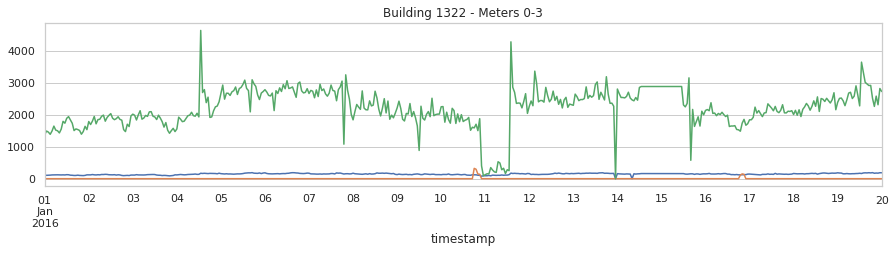

In [34]:
train.query('building_id == 1322').set_index('timestamp').groupby('meter')['meter_reading']\
.plot(figsize=(15,3),title="Building 1322 - Meters 0-3")
plt.show()

### Using Building Metadata¶

In [35]:
build.describe()

,site_id,building_id,square_feet,year_built,floor_count
count,1449.000000,1449.000000,1449.000000,675.000000,355.000000
mean,6.952381,724.000000,92111.776398,1967.957037,3.740845
std,5.003432,418.434583,110769.950997,31.054030,3.333683
min,0.000000,0.000000,283.000000,1900.000000,1.000000
25%,3.000000,362.000000,23012.000000,1949.000000,1.000000
50%,5.000000,724.000000,57673.000000,1970.000000,3.000000
75%,13.000000,1086.000000,115676.000000,1995.000000,5.000000
max,15.000000,1448.000000,875000.000000,2017.000000,26.000000


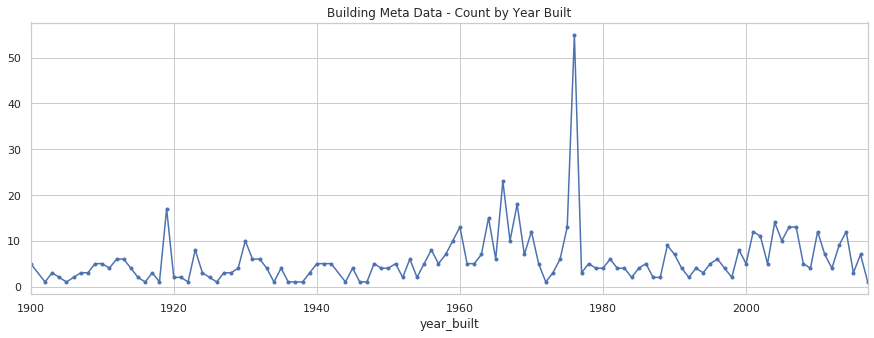

In [37]:

build.groupby('year_built')['site_id']\
.count()\
.plot(figsize=(15,5),style=".-",title=("Building Meta Data - Count by Year Built"))
plt.show()

their spike in buildings that were built in the year 1976

### Building Primary Use

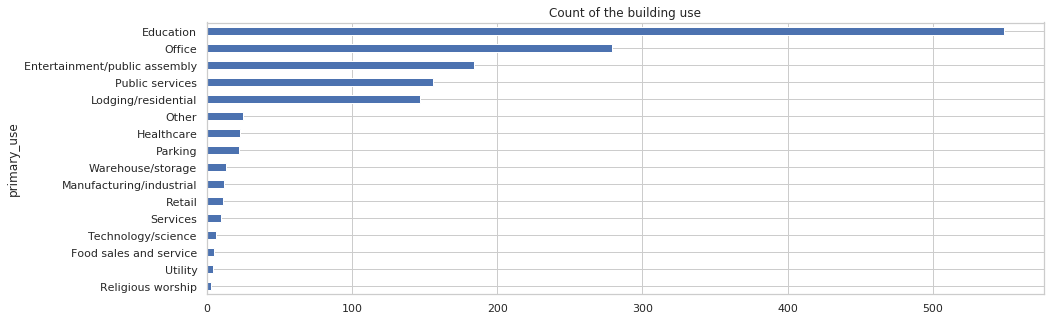

In [38]:


build.groupby('primary_use')\
.count()['site_id']\
.sort_values()\
.plot(kind='barh',figsize=(15,5),title='Count of the building use')
plt.show()

In [44]:

meter_reading_stat=train.groupby("building_id")['meter_reading'].agg(['mean','max','min']).reset_index()
meter_reading_stat.head()

,building_id,mean,max,min
0,0,0.000000,0.0000,0.0
1,1,0.447472,35.2201,0.0
2,2,0.008961,1.6381,0.0
3,3,0.000000,0.0000,0.0
4,4,0.000000,0.0000,0.0


In [47]:
buildings_stats=pd.merge(build,meter_reading_stat,on=['building_id'])\
.rename(columns={"mean":"mean_meter_reading","max":"max_meter_reading","min":"min_meter_reading"})
buildings_stats.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count,mean_meter_reading,max_meter_reading,min_meter_reading
0,0,0,Education,7432,2008.0,NaN,0.000000,0.0000,0.0
1,0,1,Education,2720,2004.0,NaN,0.447472,35.2201,0.0
2,0,2,Education,5376,1991.0,NaN,0.008961,1.6381,0.0
3,0,3,Education,23685,2002.0,NaN,0.000000,0.0000,0.0
4,0,4,Education,116607,1975.0,NaN,0.000000,0.0000,0.0


# Building Type and Meter Reading

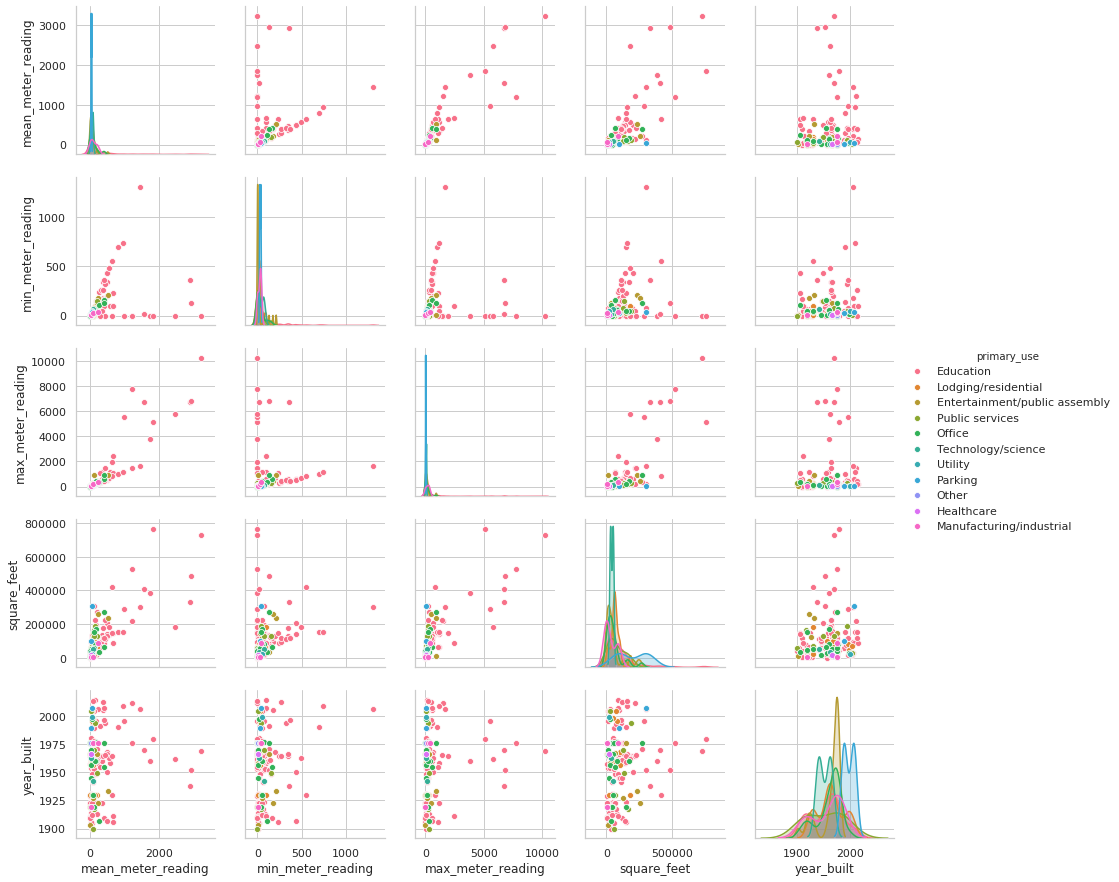

In [53]:
# import warnings
# warnings.filterwarnings("ignore",category=RuntimeWarning)
sns.pairplot(buildings_stats.dropna(),vars=['mean_meter_reading','min_meter_reading',
                                            'max_meter_reading','square_feet','year_built'],hue='primary_use')
plt.show()

### Time Series Impact on Energy Consumption

In [60]:
train['weekday']=train['timestamp'].dt.weekday
train['weekday_name']=train['timestamp'].dt.weekday_name
train['Month']=train['timestamp'].dt.month
train['DayofYear']=train['timestamp'].dt.dayofyear
train['Hour']=train['timestamp'].dt.hour


in order to properly visualize the data, we can normalize the meter reading by type. This allows us to compare how the time series features impact each meter reading type, but on the same scale. The normalized value shows the value in relation to the meter type's average.

In [62]:
#normalizing the meter readings
train['normalized_meter_reading_type']=train.groupby('meter_type')['meter_reading']\
.transform(lambda x:(x-x.mean())/x.std())
train['normalized_meter_reading_type']

0         -0.433336
1         -0.433336
2         -0.433336
3         -0.433336
4         -0.433336
             ...   
1048570    0.862494
1048571   -0.392103
1048572   -0.364294
1048573   -0.028992
1048574   -0.154773
Name: normalized_meter_reading_type, Length: 1048575, dtype: float64

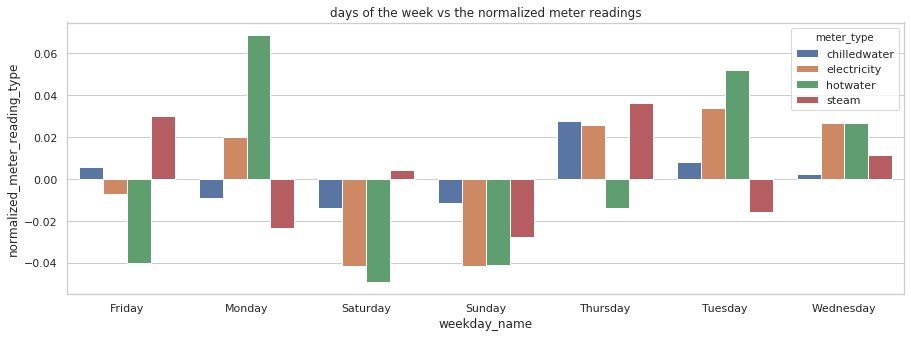

In [71]:
#visualization of the meter_readings with respend to their day fo the week
plt.figure(figsize=(15,5))
sns.barplot(data=train.groupby(['weekday_name','meter_type']).mean().reset_index(),
x='weekday_name',y='normalized_meter_reading_type',hue='meter_type')
plt.title("days of the week vs the normalized meter readings")
plt.show()


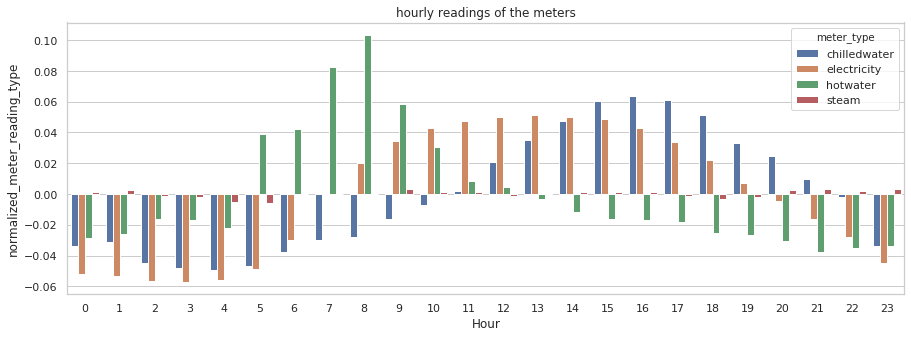

In [77]:
plt.figure(figsize=(15,5))
sns.barplot(data=train.groupby(['Hour','meter_type']).mean().reset_index(),
           y='normalized_meter_reading_type',x='Hour',hue='meter_type')
plt.title("hourly readings of the meters")
plt.show()

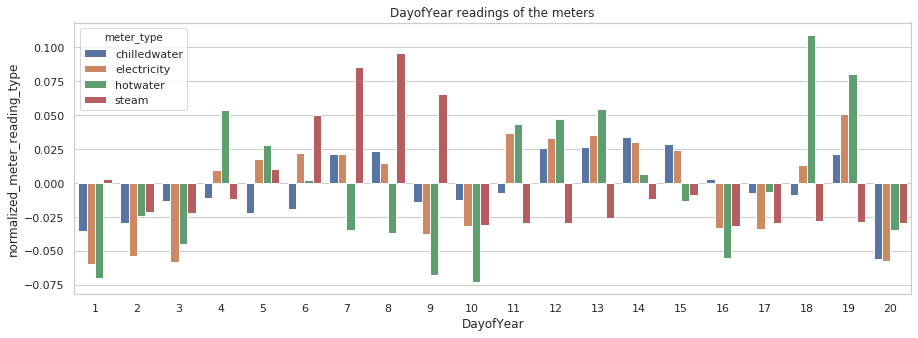

In [78]:
plt.figure(figsize=(15,5))
sns.barplot(data=train.groupby(['DayofYear','meter_type']).mean().reset_index(),
           y='normalized_meter_reading_type',x='DayofYear',hue='meter_type')
plt.title("DayofYear readings of the meters")
plt.show()